# MPC simulation for I4B – step‑by‑step

This notebook is a **cell‑based version of `run_mpc.py`**. It keeps the same structure:

1. Define models (building + heat pump)
2. Configure the MPC (Model Predictive Control) problem
3. Generate disturbances (weather, gains, grid signal)
4. Run an MPC loop: optimize, apply first input, simulate next state

Run the cells from top to bottom to reproduce what `run_mpc.py` does, but with explanations at each step.


In [ ]:
# Imports and project path setup
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# This notebook lives in notebooks/, so the repo root is one level up
I4B_ROOT = Path("..").resolve()
print("Using project root:", I4B_ROOT)

if str(I4B_ROOT) not in sys.path:
    sys.path.insert(0, str(I4B_ROOT))

from src.controller.mpc.casadi_framework import MPC_solver
import src.controller.mpc.mpc_utils as util
from timeit import default_timer as timer

import src.simulator as simulator
import src.models.model_hvac as model_hvac
import src.models.model_buildings as model_buildings
from data.buildings.sfh_1958_1968 import sfh_1958_1968_0_soc  # example building
from data.buildings.sfh_1984_1994 import sfh_1984_1994_1_enev  # example building
from data.buildings.i4c_building import i4c                  # I4C demo building
import src.disturbances as disturbances


Using project root: /Users/lillifri/Documents/Python/i4b


## Global flags and time discretization

- `SIMULATOR_ON`: if `True`, we simulate the building to get the next state.
- `GRID_ON`: if `True`, we use a time‑varying grid price signal.
- `h`: time step in seconds.
- `offset_days`: allows you to shift the starting day in the disturbance data.


In [ ]:
SIMULATOR_ON = True #False # flag whether simulation should be used to obtain next state (slower)
# GRID_ON = True  # flag whether grid supportive operation
GRID_ON = False # standard (energy efficient) operation (grid signal constant 1)

h = 3600  # length time step in s
#h = 900  # length time step in s
offset_days = 0  # in days



## Building model configuration

Here we choose:
- `method` – order of the thermal model (e.g. `'4R3C'` = 4 resistances, 3 capacitances).
- `building` – which predefined building data set to use.
- `mdot_hp` – mass flow rate in the heating circuit.

Then we instantiate `building_model`, which holds parameters and state keys.


In [ ]:
# Initialize the building model
mdot_hp = 0.25 # Massflow of the heat supply system. [kg/s]
method    = '4R3C' # model degree
#building = sfh_1958_1968_0_soc  # choose building
building = sfh_1984_1994_1_enev 
# building = i4c

# may change important parameters of building 
#building['c_bldg']=10 # thermal capacity
#building['H_tr']*=1 # heating loss of building envelope 

building_model = model_buildings.Building(params    = building, # More example buildings can be found in data/buildings/.
                                           mdot_hp   = mdot_hp,       # Massflow of the heat supply system. [kg/s]
                                           method    = method,        # For available calculation methods see: model_buildings.py.
                                           T_room_set_lower = 20,     # lower and upper comfort temperature
                                           T_room_set_upper = 26)
# additional building model (e.g. for mpc controller)
#building_model_mpc=building_model.copy()
#building_model_mpc.method='2R2C'



## Heat pump model and basic MPC settings

- Choose which heat pump model to use.
- Optionally create a simulator object wrapping the building + heat pump.
- Define MPC horizon length and cost weights.


In [ ]:
# Create HP model (uncomment selected heat pump)
#hp_model = model_hvac.Heatpump_Vitocal(mdot_HP = mdot_hp) # ground source heat pump
hp_model = model_hvac.Heatpump_AW(mdot_HP = mdot_hp) # air water heat pump

# flag whether to use simulation (default true) or mpc computation
if SIMULATOR_ON: 
   # define simulation environment with simulation model
   simulator = simulator.Model_simulator(hp_model, building_model, h)


# MPC settings
mpc_steps = 1#*24*int(3600/h) # total number of MPC iteration steps 
nk = 24*int(3600/h) # optimization/forecasting horizon (number of steps), default 1 day= 24*int(3600/h)
step_length = 1 #24*int(3600/h) # step length of mpc iteration (nk>=step_length), default 1
ws = .1 # weighting factor for temperature slack variables (balances comfort deviation vs. cost)

      
# MPC problem dimension parameters
npar = 4 # number of external parameters (time series)
nc = 4 # number of optimization constraints 
ns = 2 # number of slack variables


## MPC problem dimensions and solver setup

Here we define:
- `npar`: number of external parameters (disturbance time series).
- `nc`: number of constraints.
- `ns`: number of slack variables (soft constraint variables).
- `nx`: number of states, depending on the chosen thermal model `method`.

Then we:
- Define the result columns.
- Initialize a result file in `resultdir`.
- Create the `MPC_solver` instance `mpc`.


In [ ]:
# MPC problem dimension parameters
npar = 4 # number of external parameters (time series)
nc = 4 # number of optimization constraints 
ns = 2 # number of slack variables
if method == '2R2C':
    nx = 2 # number of states
    columns=['time','T_room','T_return','T_HP','T_amb','Qdot_gains','T_room_set_lower','grid_signal'] # column names for result file (time,x,u,P)
elif method == '4R3C':
    nx = 3
    columns=['time','T_room','T_wall','T_return','T_HP','T_amb','Qdot_gains','T_room_set_lower','grid_signal'] # (time,x,u,P)
elif method == '5R4C':
    nx = 4
    columns=['time','T_room','T_int','T_wall','T_return','T_HP','T_amb','Qdot_gains','T_room_set_lower','grid_signal'] # (time,x,u,P)


# Set-up result file
resultdir = "results_mpc"
resultfile = 'results_%s_days%d_prediction%dh_h%d'%(building['name'],mpc_steps/(24*int(3600/h)),nk/int(3600/h),h)  # result file
util.init_file(columns,resultdir,resultfile)

# define MPC solver
mpc = MPC_solver(resultdir, resultfile, hp_model, building_model,nx=nx,npar=npar,h=h,nk=nk,nc=nc,ns=ns) 




****** Result file: results_mpc/results_sfh_1984_1994_1_enev_days0_prediction24h_h3600.csv.


## Disturbances: weather, internal gains, solar gains, grid signal

We now build the disturbance dataframe `p_hourly` that contains:
- ambient temperature `T_amb`,
- combined internal + solar heat gains `Qdot_gains`,
- lower room temperature setpoint `T_room_set_lower`,
- grid signal (e.g. electricity price) `grid`.


In [ ]:
# DISTURBANCES
# Extract building location from building parameters
pos = building['position']

# Load weather data as pandas df
weather_df = disturbances.load_weather(latitude = pos['lat'],
                              longitude = pos['long'],
                              altitude  = pos['altitude'])[0:8760]

# Generate absolut heat gain profiles, based on datetime, building usage and floor area. 
int_gains_df = disturbances.get_int_gains(time = weather_df.index,
                                profile_path = '../data/profiles/InternalGains/ResidentialDetached.csv',
                                bldg_area = building['area_floor'] )
#print(int_gains_df['Qdot_tot'][:24])

# Generate profiles of solar heat gains, based on datetime and irradiance data in the weather df, 
# and the window properties defined in the building parameters.
Qdot_sol = disturbances.get_solar_gains(weather = weather_df, bldg_params = building)

# Combine all disturbances (solar gain, internal gains) into one disturbance dataframe:
#int_gains_df['Qdot_tot'] = 0
Qdot_gains = pd.DataFrame(Qdot_sol/2 + int_gains_df['Qdot_tot']/100 , columns = ['Qdot_gains']) # calculate total gains
#print(Qdot_gains[:24])
# Concatenate parameter vector
p_hourly = pd.concat([weather_df['T_amb'], Qdot_gains], axis = 1) # create new df
#p_hourly['Qdot_gains'] = 0

# Define the grid signal
data_grid = np.ones(Qdot_sol.shape[0])
# read grid data
if GRID_ON: 
   data_grid = pd.read_csv('../data\grid\grid_signals.csv',sep=',',
                           header='infer')['EEX2015'].values*0.001*5 # EUR/kWh
grid_signal = np.ones(Qdot_sol.shape[0])

# Set a lower set point temperature (e.g. night setback)
T_lower = np.ones(24)*building_model.T_room_set_lower
T_lower[:7] = 18
T_lower[21:] = 18
#p_hourly['T_amb'] = np.ones(Qdot_sol.shape[0])
p_hourly['T_room_set_lower'] = np.reshape([T_lower]*(int(np.ceil(Qdot_sol.shape[0]/24))),int(np.ceil(Qdot_sol.shape[0]/24)*24))
p_hourly['grid'] = data_grid[:Qdot_sol.shape[0]]

# set offset days in order to shift some days (default 0 offset)


48.0252 7.7184 
Found PVGIS data file data/weather/pvgis_480252_077184_2015_2015.json
48.0252 7.7184 
Found PVGIS data file data/weather/pvgis_480252_077184_tat_2015_2015.json


## Initial state and MPC loop

Now we:
- define the initial state `xk_dict` (room temperature, wall temperature, return temperature),
- resample disturbances to the simulation time step `h`,
- run the MPC loop for `mpc_steps` iterations:
  - build the disturbance horizon `P`,
  - call `mpc.update_NLP(xk)` and `mpc.solve_NLP(P, ...)` to get optimal control `uk` and predicted next state,
  - (optionally) simulate the real building with the simulator to get `xk_next`,
  - write everything to the result file.



Evaluate_ocp:
- Total consumption Qth_HP=117.75kWh (av. per day 117.75kWh), Qel_HP=32.26kWh.
- Consumer comfort deviation: av.=0.006K, max=0.12


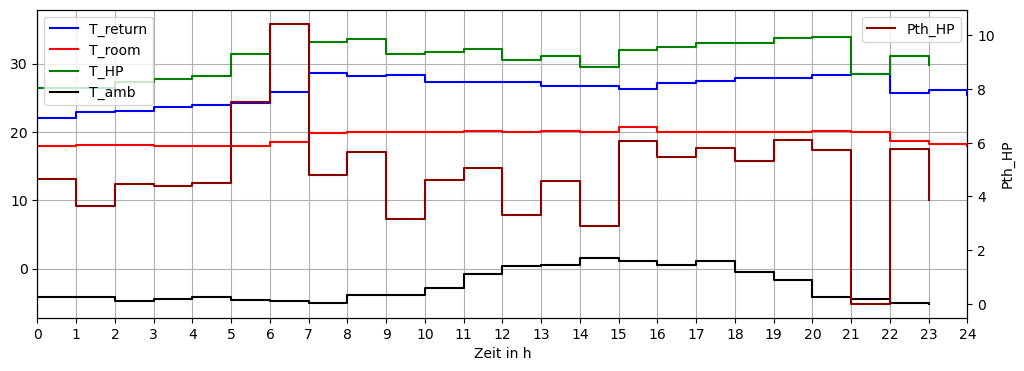

Elapsed time is 0.29s.


In [ ]:
p_hourly=p_hourly[offset_days*24:]

# resample parameter vector to new frequency
p = p_hourly.resample(f'{h}S').ffill() # resample disturbance

# example to set up an interestin scenario (24h)
#p.iloc[6:8,-1]-=.1


# Setup initial state vector
xk_dict = {key : 18 for key in building_model.state_keys} # in degC
if method != '2R2C': xk_dict['T_wall'] = 15
xk_dict['T_hp_ret'] = 22
xk_next = np.array(list(xk_dict.values())) 

# MPC iteration
start = timer()
for i in range(mpc_steps):  
   
   P = p[i*step_length:i*step_length+mpc.nk+1].values # 24 time step forecasts of [ambient temperature, heat gains]
   
   # extract initial values from dict and create np.array as required for mpc
   xk = xk_next #np.array(list(xk_dict.values())) 
   #print('Iteration',i,xk)

   # run optimizer
   mpc.update_NLP(xk)
   uk, xk_next = mpc.solve_NLP(P,mpc_steps<=1)

    
   pk = p.iloc[i].to_dict() # get disturbances of current step
   # run simulator
   if SIMULATOR_ON:
      pk = p.iloc[i].to_dict() # get disturbances of current step
      results = simulator.get_next_state(x_init = xk_dict, uk = uk, pk = pk)
      xk_dict = results['state'] # save next state
      xk_next = np.array(list(xk_dict.values())) 

   ## Add current step to file
   util.update_file(i*h,mpc.resultfile,mpc.resultdir,P,uk,xk)
   
        
print ('Elapsed time is %.2fs.' %(timer() - start))
if mpc_steps>=24: util.evaluate_mpc(hp_model,building_model,mpc.resultfile,mpc.resultdir,h=h) 
